# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [14]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import deque

%aimport agent, model

from model import QNetwork, DDQNetwork
from agent import Agent_no_soft_update, Agent, PERAgent


In [3]:
env = UnityEnvironment(file_name="Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]
state_size=len(env_info.vector_observations[0])
action_size=brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, file= 'checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    solved = False
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]    
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps) # you have to convert it to np.int32 for windows 10 
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0] 
            reward = env_info.rewards[0]
            done = env_info.local_done[0]  
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if solved == False and np.mean(scores_window)>=13.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
    if solved:
        torch.save(agent.qnetwork_local.state_dict(), file)
    return scores


In [9]:
def load_and_play(agent, file):
    
    if agent is None:
        print('no agent')
        return None
    agent.qnetwork_local.load_state_dict(torch.load(file, map_location= 'cpu'))

    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    
    print("Score: {}".format(score))

#### 4.1 DQN without soft update

Episode 100	Average Score: -0.09
Episode 200	Average Score: 0.322
Episode 300	Average Score: 1.27
Episode 400	Average Score: 5.77
Episode 500	Average Score: 5.19
Episode 600	Average Score: 9.90
Episode 700	Average Score: 10.35
Episode 800	Average Score: 11.46
Episode 900	Average Score: 12.79
Episode 918	Average Score: 13.02
Environment solved in 818 episodes!	Average Score: 13.02
Episode 1000	Average Score: 13.34
Episode 1100	Average Score: 12.57
Episode 1200	Average Score: 13.47
Episode 1300	Average Score: 12.06
Episode 1400	Average Score: 12.45
Episode 1500	Average Score: 12.95
Episode 1600	Average Score: 12.04
Episode 1700	Average Score: 12.40
Episode 1800	Average Score: 12.57
Episode 1900	Average Score: 13.30
Episode 2000	Average Score: 12.53


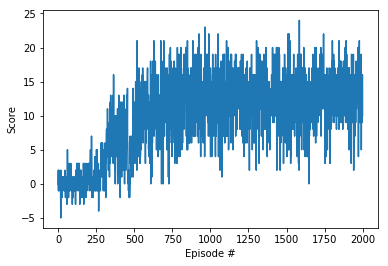

In [10]:
file = 'DQN_no_soft_update.pth'
agent = Agent_no_soft_update(state_size, action_size, seed=0)
scores = dqn(file= file)


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### replay DQN without soft update

In [6]:
file = 'DQN_no_soft_update.pth'
agent = Agent_no_soft_update(state_size, action_size, seed=0)
load_and_play(agent, file)

RuntimeError: Error(s) in loading state_dict for QNetwork:
	Missing key(s) in state_dict: "hidden_layers.0.weight", "hidden_layers.0.bias", "hidden_layers.1.weight", "hidden_layers.1.bias", "output.weight", "output.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 

#### 4.2 DQN with soft update

Episode 100	Average Score: 0.81
Episode 200	Average Score: 4.43
Episode 300	Average Score: 8.16
Episode 400	Average Score: 10.41
Episode 500	Average Score: 12.53
Episode 524	Average Score: 13.02
Environment solved in 424 episodes!	Average Score: 13.02
Episode 600	Average Score: 13.43
Episode 700	Average Score: 13.96
Episode 800	Average Score: 15.00
Episode 900	Average Score: 14.90
Episode 1000	Average Score: 14.60
Episode 1100	Average Score: 15.48
Episode 1200	Average Score: 15.47
Episode 1300	Average Score: 14.44
Episode 1400	Average Score: 14.91
Episode 1500	Average Score: 14.52
Episode 1600	Average Score: 14.74
Episode 1700	Average Score: 15.34
Episode 1800	Average Score: 14.53
Episode 1900	Average Score: 14.34
Episode 2000	Average Score: 15.33


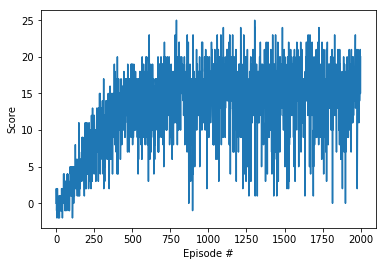

In [10]:
file = 'DQN_with_soft_update.pth'
agent = Agent(state_size, action_size, seed=0, dueling= False, double= False)
scores = dqn(file= file)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
file = 'DQN_with_soft_update.pth'
agent = Agent(state_size, action_size, seed=0, dueling= False, double= False)
load_and_play(agent, file)

RuntimeError: Error(s) in loading state_dict for QNetwork:
	Missing key(s) in state_dict: "hidden_layers.0.weight", "hidden_layers.0.bias", "hidden_layers.1.weight", "hidden_layers.1.bias", "output.weight", "output.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 

#### replay DQN with soft update

In [37]:
file = 'DQN_with_soft_update.pth'
agent = Agent(state_size, action_size, seed=0, dueling= False, double= False)
load_and_play(agent, file)

Score: 16.0


#### 4.3 Double DQN with soft update

https://arxiv.org/abs/1509.06461

Episode 100	Average Score: 0.73
Episode 200	Average Score: 4.37
Episode 300	Average Score: 8.19
Episode 400	Average Score: 10.55
Episode 500	Average Score: 12.64
Episode 520	Average Score: 13.04
Environment solved in 420 episodes!	Average Score: 13.04
Episode 600	Average Score: 14.80
Episode 700	Average Score: 14.53
Episode 800	Average Score: 15.33
Episode 900	Average Score: 14.17
Episode 1000	Average Score: 14.57
Episode 1100	Average Score: 14.73
Episode 1200	Average Score: 14.98
Episode 1300	Average Score: 14.89
Episode 1400	Average Score: 15.32
Episode 1500	Average Score: 14.85
Episode 1600	Average Score: 14.11
Episode 1700	Average Score: 14.62
Episode 1800	Average Score: 14.37
Episode 1900	Average Score: 16.19
Episode 2000	Average Score: 15.26


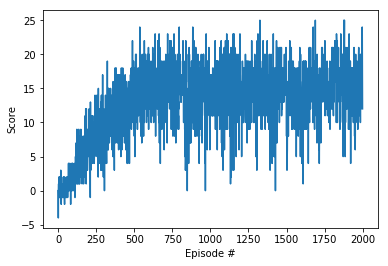

In [11]:
file = 'Double_DQN_with_soft_update.pth'
agent = Agent(state_size, action_size, seed=0, dueling= False, double= True)
scores = dqn(file = file)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### replay Double DQN with soft update

In [11]:
agent = Agent(state_size, action_size, seed=0, dueling= False, double= True)
file = 'Double_DQN_with_soft_update.pth'
load_and_play(agent, file)

RuntimeError: Error(s) in loading state_dict for QNetwork:
	Missing key(s) in state_dict: "hidden_layers.0.weight", "hidden_layers.0.bias", "hidden_layers.1.weight", "hidden_layers.1.bias", "output.weight", "output.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 

#### 4.4 Dueling DQN
$$ Q = V + A - mean(A)$$

Episode 100	Average Score: 0.12
Episode 200	Average Score: 3.75
Episode 300	Average Score: 8.04
Episode 400	Average Score: 10.06
Episode 500	Average Score: 12.68
Episode 527	Average Score: 13.01
Environment solved in 427 episodes!	Average Score: 13.01
Episode 600	Average Score: 13.65
Episode 700	Average Score: 14.04
Episode 800	Average Score: 14.45
Episode 900	Average Score: 14.18
Episode 1000	Average Score: 15.60
Episode 1100	Average Score: 14.99
Episode 1200	Average Score: 16.35
Episode 1300	Average Score: 14.70
Episode 1400	Average Score: 14.39
Episode 1500	Average Score: 15.57
Episode 1600	Average Score: 16.19
Episode 1700	Average Score: 14.54
Episode 1800	Average Score: 15.50
Episode 1900	Average Score: 16.26
Episode 2000	Average Score: 14.29


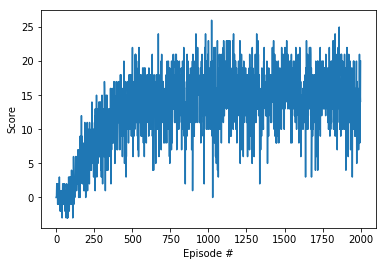

In [11]:
file = 'Dueling_DQN_with_soft_update.pth'
agent = Agent(state_size, action_size, seed=0, dueling= True, double= False)
scores = dqn(file = file)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### replay Dueling DQN

In [12]:
agent = Agent(state_size, action_size, seed=0, dueling= True, double= False)
file = 'Dueling_DQN_with_soft_update.pth'
load_and_play(agent, file)

RuntimeError: Error(s) in loading state_dict for DDQNetwork:
	Missing key(s) in state_dict: "hidden_layers.0.weight", "hidden_layers.0.bias", "hidden_layers.1.weight", "hidden_layers.1.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

#### Dueling and Double DQN

Episode 100	Average Score: 0.62
Episode 200	Average Score: 2.22
Episode 300	Average Score: 4.67
Episode 400	Average Score: 9.43
Episode 500	Average Score: 12.25
Episode 561	Average Score: 13.04
Environment solved in 461 episodes!	Average Score: 13.04
Episode 600	Average Score: 14.11
Episode 700	Average Score: 14.70
Episode 800	Average Score: 15.04
Episode 900	Average Score: 15.32
Episode 1000	Average Score: 14.60
Episode 1100	Average Score: 15.19
Episode 1200	Average Score: 15.86
Episode 1300	Average Score: 16.34
Episode 1400	Average Score: 14.89
Episode 1500	Average Score: 14.46
Episode 1600	Average Score: 15.54
Episode 1700	Average Score: 15.86
Episode 1800	Average Score: 16.15
Episode 1900	Average Score: 16.23
Episode 2000	Average Score: 16.22


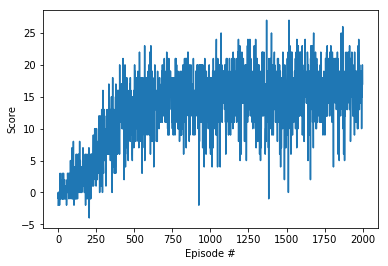

In [13]:
file = 'Dueling_Double_DQN_with_soft_update.pth'
agent = Agent(state_size, action_size, seed=0, dueling= True, double= True)
scores = dqn(file= file)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### replay Dueling and Double DQN

In [13]:
agent = Agent(state_size, action_size, seed=0, dueling= True, double= True)
file = 'Dueling_Double_DQN_with_soft_update.pth'
load_and_play(agent, file)

RuntimeError: Error(s) in loading state_dict for DDQNetwork:
	Missing key(s) in state_dict: "hidden_layers.0.weight", "hidden_layers.0.bias", "hidden_layers.1.weight", "hidden_layers.1.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

### Experiments

default parameters

hidden_layers = [64, 32]  
LR = 0.0005  
BUFFER_SIZE = 10000  
BATCH_SIZE = 64  
GAMMA = 0.99  
UPDATE_EVERY = 4  
TAU = 0.001  


performance(reward) of the default parameters is around 15

- BUFFER_SIZE = 50000, performance is around 16
- only add (S,A,R,S) when R > 0, not work, the average reward < 1
- only add (S,A,R,S) when R > -2, works, but same performance
- only add (S,A,R,S) when R > -1, works, performance is around 13
- eps_start=0.1, eps_end= 0.00001, solved in 242 eposodes, which is fast. Performance is around 16, can get to 17.
- eps_start=0.1, eps_end= 0.000001, BUFFER_SIZE = 100000, unalble to solve, performance is around 9
- eps_start=0.1, eps_end= 0.000001, learning rate = 0.005, unable to solve, performance is around 10.


Episode 100	Average Score: 0.63
Episode 200	Average Score: 5.36
Episode 300	Average Score: 10.24
Episode 383	Average Score: 13.02
Environment solved in 283 episodes!	Average Score: 13.02
Episode 400	Average Score: 13.49
Episode 500	Average Score: 15.34


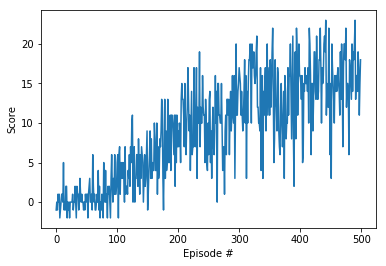

In [25]:
file = 'fastest_agent.pth'
agent = Agent(state_size, action_size, seed=0, dueling= True, double= True)
scores = dqn(eps_start=0.1, eps_end=0.00001, n_episodes=500, file= file)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### DQN with prioritized experience replay

reference:  
https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/
https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682



Episode 100	Average Score: 0.87
Episode 200	Average Score: 3.70
Episode 300	Average Score: 4.67
Episode 400	Average Score: 7.87
Episode 500	Average Score: 7.46
Episode 600	Average Score: 7.42
Episode 700	Average Score: 7.61
Episode 800	Average Score: 8.51
Episode 900	Average Score: 9.15
Episode 1000	Average Score: 9.89
Episode 1100	Average Score: 10.63
Episode 1200	Average Score: 10.58
Episode 1300	Average Score: 10.93
Episode 1400	Average Score: 10.01
Episode 1500	Average Score: 11.24
Episode 1600	Average Score: 11.44
Episode 1700	Average Score: 10.94
Episode 1800	Average Score: 11.68
Episode 1900	Average Score: 10.42
Episode 2000	Average Score: 10.41


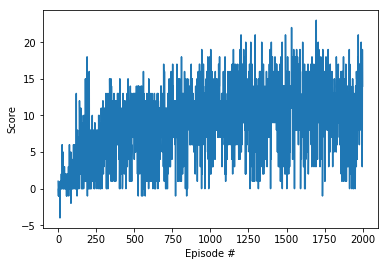

In [27]:
agent = PERAgent(state_size, action_size, seed=0, dueling= True, double= True)
scores = dqn(eps_start=0.5, eps_end=0.001, eps_decay=0.8, n_episodes= 2000)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()